# ArUco Marker Detector
Detect ArUco markers in an image.

**How to use**
1. Set `ARUCO_DICT_NAME` and `IMAGE_PATH` in the first code cell.
2. Run all cells.
3. The notebook will display the annotated image and print detected IDs.

**Notes**
- This notebook tries to `import cv2`; if missing, it installs `opencv-contrib-python`.
- Works with both new (`cv2.aruco.ArucoDetector`) and legacy (`cv2.aruco.detectMarkers`) APIs.
- Supported dict names include: `DICT_4X4_50`, `DICT_4X4_100`, `DICT_5X5_50`, `DICT_5X5_100`, `DICT_6X6_50`, `DICT_6X6_100`, `DICT_7X7_50`, `DICT_7X7_100`, `DICT_ARUCO_ORIGINAL`.
- If your path has non-ASCII characters, the loader handles it.

In [41]:
# === User Input ===
# Pick one of the supported ArUco dictionaries (case-insensitive string)
ARUCO_DICT_NAME = "DICT_4X4_100"   # e.g., "DICT_6X6_100", "DICT_ARUCO_ORIGINAL"

# Path to your input image (absolute or relative). Examples:
# IMAGE_PATH = "sample.jpg"
# IMAGE_PATH = r"C:\data\aruco.png"
IMAGE_PATH = "./aruco/aruco.bmp"

# Whether to save the annotated output
SAVE_ANNOTATED = True
OUTPUT_PATH = "aruco.png"  # will save next to the notebook by default

# Optional: tweak detector parameters
ADAPTIVE_THRESH_CONSTANT = 7
MIN_MARKER_PERIMETER_RATE = 0.03
MAX_MARKER_PERIMETER_RATE = 4.0
POLY_APPROX_ACCURACY_RATE = 0.03
PERSPECTIVE_REMOVE_PIXEL_PER_CELL = 4
PERSPECTIVE_REMOVE_IGNORE_BORDER = 0
MARKER_BORDER_BITS = 1
USE_REFINE = True   # run corner refinement if available


In [42]:
# === Install & Imports ===
import sys, subprocess

def _install(package):
    print(f"Installing {package} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    import cv2  # type: ignore
except Exception as e:
    print("OpenCV not found. Installing opencv-contrib-python ...")
    _install("opencv-contrib-python")
    import cv2  # type: ignore

import numpy as np
import os
from pathlib import Path
from typing import Optional, Tuple
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.10.0


In [43]:
# === Helpers ===
def imread_any(path: str):
    """Robust image read that supports Unicode windows paths."""
    path = str(path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")
    # Use np.fromfile to support unicode paths on Windows
    data = np.fromfile(path, dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    return img

def get_aruco_dictionary(name: str):
    """Return cv2.aruco predefined dictionary by name (case-insensitive)."""
    name = name.upper().strip()
    # Prefer dynamic getter when available
    if hasattr(cv2.aruco, "getPredefinedDictionary"):
        try:
            return cv2.aruco.getPredefinedDictionary(getattr(cv2.aruco, name))
        except Exception:
            pass
    # Fallback to attribute lookup
    if hasattr(cv2.aruco, name):
        return getattr(cv2.aruco, name)
    # Common aliases
    aliases = {
        "DICT_ARUCO_ORIGINAL": "DICT_ARUCO_ORIGINAL",
        "ARUCO_ORIGINAL": "DICT_ARUCO_ORIGINAL",
    }
    if name in aliases and hasattr(cv2.aruco, aliases[name]):
        return getattr(cv2.aruco, aliases[name])
    raise ValueError(f"Unknown/unsupported ArUco dictionary: {name}")

def build_detector_params():
    params = cv2.aruco.DetectorParameters_create() if hasattr(cv2.aruco, "DetectorParameters_create") else cv2.aruco.DetectorParameters()
    # Set a few robust defaults / user inputs
    if hasattr(params, "adaptiveThreshConstant"):
        params.adaptiveThreshConstant = ADAPTIVE_THRESH_CONSTANT
    if hasattr(params, "minMarkerPerimeterRate"):
        params.minMarkerPerimeterRate = MIN_MARKER_PERIMETER_RATE
    if hasattr(params, "maxMarkerPerimeterRate"):
        params.maxMarkerPerimeterRate = MAX_MARKER_PERIMETER_RATE
    if hasattr(params, "polygonalApproxAccuracyRate"):
        params.polygonalApproxAccuracyRate = POLY_APPROX_ACCURACY_RATE
    if hasattr(params, "perspectiveRemovePixelPerCell"):
        params.perspectiveRemovePixelPerCell = PERSPECTIVE_REMOVE_PIXEL_PER_CELL
    if hasattr(params, "perspectiveRemoveIgnoredMarginPerCell"):
        params.perspectiveRemoveIgnoredMarginPerCell = PERSPECTIVE_REMOVE_IGNORE_BORDER
    if hasattr(params, "markerBorderBits"):
        params.markerBorderBits = MARKER_BORDER_BITS
    return params

def detect_aruco(image_bgr, dict_name: str, use_refine: bool = True):
    """Detect ArUco markers and return (corners, ids, rejected)."""
    dictionary = get_aruco_dictionary(dict_name)
    params = build_detector_params()

    # New API (OpenCV >= 4.7): ArucoDetector
    if hasattr(cv2.aruco, "ArucoDetector"):
        detector = cv2.aruco.ArucoDetector(dictionary, params)
        corners, ids, rejected = detector.detectMarkers(image_bgr)
        # Optional refine step if available
        if use_refine and hasattr(cv2.aruco, "refineDetectedMarkers"):
            # To refine we need a board; if none, we can still call with defaults (no board)
            # In practice refine without a board may not change results; we keep it optional.
            try:
                corners, ids, rejected, _ = cv2.aruco.refineDetectedMarkers(
                    image_bgr, cv2.aruco.Board_create([], [], []), corners, ids, rejected, dictionary, params
                )
            except Exception:
                pass
        return corners, ids, rejected

    # Legacy API
    corners, ids, rejected = cv2.aruco.detectMarkers(image_bgr, dictionary, parameters=params)
    if use_refine and hasattr(cv2.aruco, "refineDetectedMarkers"):
        try:
            corners, ids, rejected, _ = cv2.aruco.refineDetectedMarkers(
                image_bgr, cv2.aruco.Board_create([], [], []), corners, ids, rejected, dictionary, params
            )
        except Exception:
            pass
    return corners, ids, rejected

def draw_detections(image_bgr, corners, ids):
    out = image_bgr.copy()
    if ids is not None and len(ids) > 0:
        cv2.aruco.drawDetectedMarkers(out, corners, ids)
        # Draw centers
        for cs in corners:
            c = cs.reshape(-1, 2).mean(axis=0).astype(int)
            cv2.circle(out, tuple(c), 4, (0, 0, 255), -1, lineType=cv2.LINE_AA)
    return out


Detected markers: 4
IDs: [0, 1, 3, 2]
Annotated saved to: C:\Users\AIKENSA 6GO\Documents\AIKENSA_AGC\aikensa_agc\aikensa\tools\aruco.png


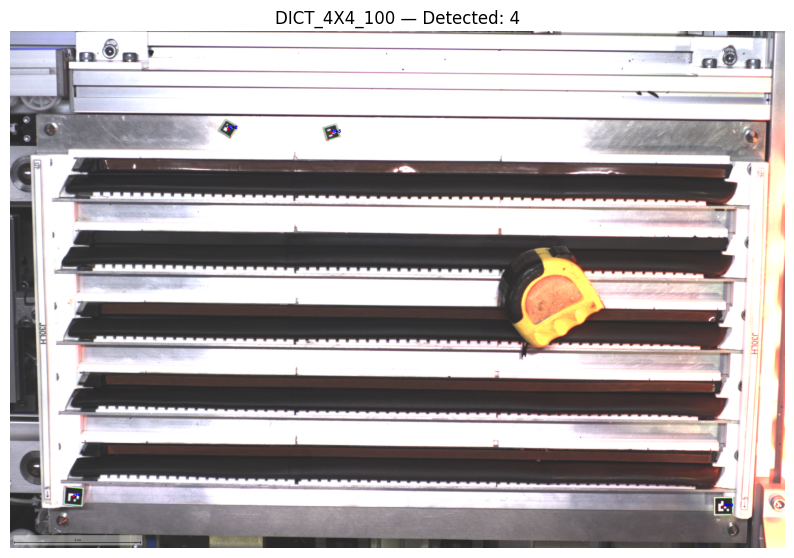

In [44]:
# === Run Detection ===
# Load
img_bgr = imread_any(IMAGE_PATH)

# Detect
corners, ids, rejected = detect_aruco(img_bgr, ARUCO_DICT_NAME, use_refine=USE_REFINE)

# Report
num = 0 if ids is None else int(len(ids))
print(f"Detected markers: {num}")
if ids is not None:
    print("IDs:", ids.flatten().tolist())

# Draw + show
annotated = draw_detections(img_bgr, corners, ids)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"{ARUCO_DICT_NAME} — Detected: {num}")

# Save
if SAVE_ANNOTATED:
    out_path = Path(OUTPUT_PATH).expanduser().resolve()
    # Safe write (handles unicode)
    data = cv2.imencode('.png', annotated)[1]
    out_path.write_bytes(data.tobytes())
    print("Annotated saved to:", out_path)
